In [28]:
import numpy as np
from cmocean import cm
import cartopy as cp
import cartopy.crs as ccrs
import netCDF4 as nc
import matplotlib.pyplot as plt
import xarray as xr

%matplotlib inline
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')
import cartopy.feature as cfeature
from importlib import reload
import matplotlib.path as mpath
import glob
import pickle
import pandas as pd
import seawater
import time
plt.rcParams.update({'font.size': 13})
font = {'family' : 'normal',
'weight' : 'normal',
'size'   : 13}
plt.rcParams['text.usetex'] = True
plt.rc('font', **font)

### data preparation: calculate each ensemble member ts 

- first make nice daily files in extractAndProcessCode/04_get_nice_daily_files_for_each_reanalysis.ipynb
    (this includes concatenation step)
- then make a ts for each EM in extract_ts_3M.py

### make ensemble average for final plot

In [29]:
ex = False 

def make_ensemble_avg(e1,e2,e3, tlat = '40-60'):
    print(f'EM {e1}')
    tdir = '/gpfs/data/greenocean2/software/products/windsFromComponents/dailyStandard/intProc/'
    e1d = xr.open_dataset(f'{tdir}/scen{e1}_UKESM_{tlat}S_mean_wspd_ts_1950-2099.nc')
    e2d = xr.open_dataset(f'{tdir}/scen{e2}_UKESM_{tlat}S_mean_wspd_ts_1950-2099.nc')
    e3d = xr.open_dataset(f'{tdir}/scen{e3}_UKESM_{tlat}S_mean_wspd_ts_1950-2099.nc')

    # Compute the average of the 'wspd10m' variable across the datasets
    wspd10m_avg = (e1d['wspd10m'] + e2d['wspd10m'] + e3d['wspd10m']) / 3

    # Create a new dataset with the averaged variable
    d4 = xr.Dataset({'wspd10m': wspd10m_avg})

    # Optionally, copy attributes from one of the datasets to the new one
    d4['wspd10m'].attrs = e1d['wspd10m'].attrs
    d4.attrs = {"made in": 'windEval/plottingCode/Fig-attribution3M.ipynb'}
    
    d4.to_netcdf(f'{tdir}/scen{e1}EM_UKESM_{tlat}S_mean_wspd_ts_1950-2099.nc')
    
    return d4

if ex:
    d4 = make_ensemble_avg('1A','1AM2','1AM3')
    d4 = make_ensemble_avg('1B','1BM2','1BM3')
    d4 = make_ensemble_avg('2A','2AM2','2AM3')
    d4 = make_ensemble_avg('2B','2BM2','2BM3')
# # Save or further process the new dataset
# print(d4)



In [30]:
import numpy as np


import pymannkendall as mk
from scipy import stats

def give_trends(ts_y):

    ts_x = np.arange(0,len(ts_y))
    trend, h, mk_p, z, Tau, s, var_s, mk_slope, intercept = mk.original_test(ts_y)
    lin_slope, intercept, r_value, lin_p, std_err = stats.linregress(ts_x,ts_y)
    
    return mk_slope, mk_p, lin_slope, lin_p

### dictionary for colours and names

In [31]:
tlw = 0.5

m3dict = {
    '1A': {'name': '','color':'darkgray','linestyle' : '-','linewidth' : tlw},
    '1AM2': {'name': '','color':'darkgray','linestyle' : ':','linewidth' : tlw},
    '1AM3': {'name': '','color':'darkgray','linestyle' : '--','linewidth' : tlw},
    '1AEM': {'name': 'SSP 1-2.6 \n OZONE-HIST.','color':'darkgray','linestyle' : '-','linewidth' : 2.5,},

    '1B': {'name': '','color':'black','linestyle' : '-','linewidth' : tlw},
    '1BM2': {'name': '','color':'black','linestyle' : ':','linewidth' : tlw},
    '1BM3': {'name': '','color':'black','linestyle' : '--','linewidth' : tlw},
    '1BEM': {'name': 'SSP 3-7.0 \n OZOZE-HIST.','color':'black','linestyle' : '-','linewidth' : 2.5,},
    
    '2A': {'name': '','color':'mediumaquamarine','linestyle' : '-','linewidth' : tlw},
    '2AM2': {'name': '','color':'mediumaquamarine','linestyle' : ':','linewidth' : tlw},
    '2AM3': {'name': '','color':'mediumaquamarine','linestyle' : '--','linewidth' : tlw},
    '2AEM': {'name': 'SSP 1-2.6 \n OZONE-1950','color':'mediumaquamarine','linestyle' : '-','linewidth' : 2.5,},

    '2B': {'name': '','color':'forestgreen','linestyle' : '-','linewidth' : tlw},
    '2BM2': {'name': '','color':'forestgreen','linestyle' : ':','linewidth' : tlw},
    '2BM3': {'name': '','color':'forestgreen','linestyle' : '--','linewidth' : tlw},
    '2BEM': {'name': 'SSP 3-7.0 \n OZONE-1950','color':'forestgreen','linestyle' : '-','linewidth' : 2.5,},    
}



# PAPER FIGURE timeseries of 1950-2100 winds for bands 40-60 



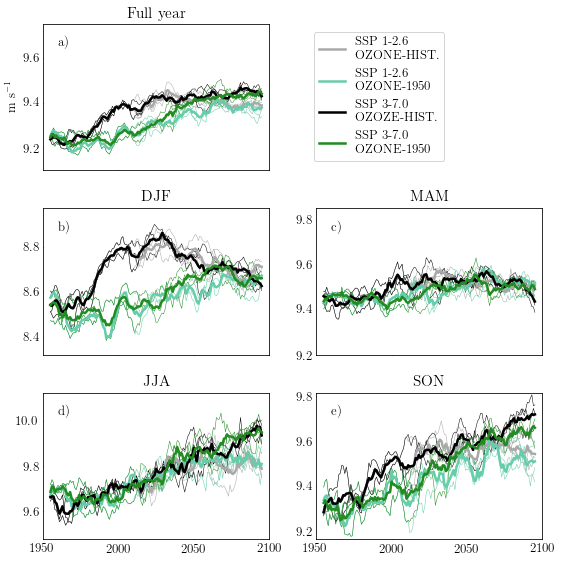

In [32]:

scens = ['1A','1B','2A','2B','1AM2','1BM2','2AM2','2BM2',\
         '1AM3','1BM3','2AM3','2BM3','1AEM','2AEM','1BEM','2BEM']
stl = ['1AEM','2AEM','1BEM','2BEM']
latdegs = ['40-60S']#,'30-70S']

for latdeg in latdegs:

    fact = 1
    fig, axs = plt.subplots(3,2, figsize=(8*fact, 8*fact), sharex=False, sharey=False)
    axs = axs.ravel()


    ts = ['DJF','MAM','JJA','SON']

    for s in scens:
        tdir = '/gpfs/data/greenocean2/software/products/windsFromComponents/dailyStandard/intProc/'
        td = xr.open_dataset(f'{tdir}/scen{s}_UKESM_{latdeg}_mean_wspd_ts_1950-2099.nc')
        g = td.groupby('time_counter.year').mean()

        tv_rol = g.rolling(year=10, center=True).mean()

        #axs[0].plot(g.year,g.wspd10m, color = m3dict[s]['color'], linewidth = m3dict[s]['linewidth'],)
        if s in stl:
            axs[0].plot(tv_rol.year,tv_rol.wspd10m, color = m3dict[s]['color'],\
                        linewidth = m3dict[s]['linewidth'], label = m3dict[s]['name'])    
        else:
            axs[0].plot(tv_rol.year,tv_rol.wspd10m, color = m3dict[s]['color'],\
                        linewidth = m3dict[s]['linewidth'],)



        for i in range(0,4):
            g = td.sel(time_counter=(td['time_counter.season'] == ts[i])).groupby('time_counter.year').mean()
            tv_rol = g.rolling(year=10, center=True).mean()
            axs[i+2].plot(tv_rol.year,tv_rol.wspd10m, color = m3dict[s]['color'], linewidth = m3dict[s]['linewidth'],)

        axs[1].axis('off')

    tmin = [9.1,8.32,9.2,9.475,9.165]
    if latdeg == '30-70S':
        tmin = [8.2,7.35,8.35,8.8,8.25]
    lab = ['a)','b)','c)','d)','e)','b)'] 
    tits = ['Full year','DJF','MAM','JJA','SON']
    ofs = 0.65
    ind = 0
    for i in range(0,6):

        if i != 1:
            axs[i].set_xlim([1950,2100])
            axs[i].set_xticks(np.arange(1950,2150,50))
            axs[i].set_xticklabels([])
            axs[i].set_ylim([tmin[ind],tmin[ind]+ofs])
            axs[i].text(1960,tmin[ind]+0.85*ofs,lab[ind])
            axs[i].tick_params(axis='x', length=0.5)
            axs[i].tick_params(axis='y', length=0.5)
            #axs[i].grid()

            axs[i].set_title(tits[ind])
            ind = ind+1

    axs[0].set_ylabel('m s$^{-1}$')
    axs[4].set_xticklabels(np.arange(1950,2150,50))
    axs[5].set_xticklabels(np.arange(1950,2150,50))

    handles, labels = axs[0].get_legend_handles_labels()  # Collect handles and labels from a subplot


    fig.legend(handles, labels, loc='center', bbox_to_anchor=(0.67, 0.82))
    #fig.suptitle(f'UKESM 10m winds {latdeg}')
    plt.tight_layout()

    fig.savefig(f'./plts/Fig6-ts.jpg', dpi = 300)


### trends and significances of ensemble mean only, 40-60 



In [33]:
import pymannkendall as mk
from scipy import stats

def give_trends(ts_y):

    ts_x = np.arange(0,len(ts_y))
    trend, h, mk_p, z, Tau, s, var_s, mk_slope, intercept = mk.original_test(ts_y)
    lin_slope, intercept, r_value, lin_p, std_err = stats.linregress(ts_x,ts_y)
    
    return mk_slope, mk_p, lin_slope, lin_p

In [34]:
latdeg = '40-60S'

d2A = xr.open_dataset(f'{tdir}/scen2AEM_UKESM_{latdeg}_mean_wspd_ts_1950-2099.nc')
d1A = xr.open_dataset(f'{tdir}/scen1AEM_UKESM_{latdeg}_mean_wspd_ts_1950-2099.nc')
d2B = xr.open_dataset(f'{tdir}/scen2BEM_UKESM_{latdeg}_mean_wspd_ts_1950-2099.nc')
d1B = xr.open_dataset(f'{tdir}/scen1BEM_UKESM_{latdeg}_mean_wspd_ts_1950-2099.nc')
dO3A = d1A-d2A
dO3B = d1B-d2B



In [35]:
def get_trend_sig(ts,y1,y2,seas):
    
    if seas == 'FY':
        g = ts.wspd10m.groupby('time_counter.year').mean().sel(year=slice(y1,y2)).values
        mk_slope, mk_p, lin_slope, lin_p = give_trends(g)
        lin_slope = lin_slope*10
    else:
        g = ts.wspd10m.sel(time_counter=(td['time_counter.season'] == seas)).\
        groupby('time_counter.year').mean().sel(year=slice(y1,y2)).values         
        mk_slope, mk_p, lin_slope, lin_p = give_trends(g)
        lin_slope = lin_slope*10
        
    return lin_slope, lin_p

lin_slope, lin_p = get_trend_sig(d1A,1950,1999,'DJF')
print(f'{lin_slope}, {lin_p}')

0.055829366104686966, 1.5169490440040577e-08


In [36]:
y1 = 1950; y2 = 1999; latdeg = '40-60S'

def get_ukesm3m(y1,y2, latdeg = '40-60S'):
    print(f'{y1}-{y2}')

    data = np.zeros([5,6])
    data2 = np.zeros([5,6])

    tdir = '/gpfs/data/greenocean2/software/products/windsFromComponents/dailyStandard/intProc/'

    d2A = xr.open_dataset(f'{tdir}/scen2AEM_UKESM_{latdeg}_mean_wspd_ts_1950-2099.nc')
    d1A = xr.open_dataset(f'{tdir}/scen1AEM_UKESM_{latdeg}_mean_wspd_ts_1950-2099.nc')
    d2B = xr.open_dataset(f'{tdir}/scen2BEM_UKESM_{latdeg}_mean_wspd_ts_1950-2099.nc')
    d1B = xr.open_dataset(f'{tdir}/scen1BEM_UKESM_{latdeg}_mean_wspd_ts_1950-2099.nc')
    dO3A = d1A-d2A
    dO3B = d1B-d2B


    ems = [d2A,dO3A,d1A,d2B,dO3B,d1B,]
    emn = ['d2A','dO3A','d1A','d2B','dO3B','d1B',]

    df = pd.DataFrame(data, columns=emn,\
                      index  = ['FY','DJF','MAM', 'JJA', 'SON',])
    df2 = pd.DataFrame(data2, columns=emn,\
                      index  = ['FY','DJF','MAM', 'JJA', 'SON',])

    seas = ['FY','DJF','MAM', 'JJA', 'SON',]
    for e in range(0,6):
        for s in seas:
            ts = ems[e]
            tn = emn[e]
            lin_slope, lin_p = get_trend_sig(ts,y1,y2,s)
            df.loc[s, tn] = lin_slope
            if lin_p < 0.05:
                df2.loc[s, tn] = lin_slope


    df.attrs = {"made in": 'plottingCode/Fig-attribution3M.ipynb'}
    df.to_csv(f'./plts/attr-UKESM3M_{latdeg}-trend-{y1}-{y2}.csv')
    df2.attrs = {"made in": 'plottingCode/Fig-attribution3M.ipynb'}
    df2.to_csv(f'./plts/attr-UKESM3M_{latdeg}-trendsig-{y1}-{y2}.csv')
    print('saved')



In [37]:
y1 = 1950; y2 = 1999; latdeg = '40-60S'

ex = False
if ex:
    get_ukesm3m(1950,1999)
    get_ukesm3m(2000,2049)
    get_ukesm3m(2050,2099)

if ex:
    get_ukesm3m(1980,1999)
    get_ukesm3m(1980,2019)
    #get_ukesm3m(2050,2099)

1950-1999
saved
2000-2049
saved
2050-2099
saved
1980-1999
saved
1980-2019
saved


### bonus: decomposition into ghg and ozone signal

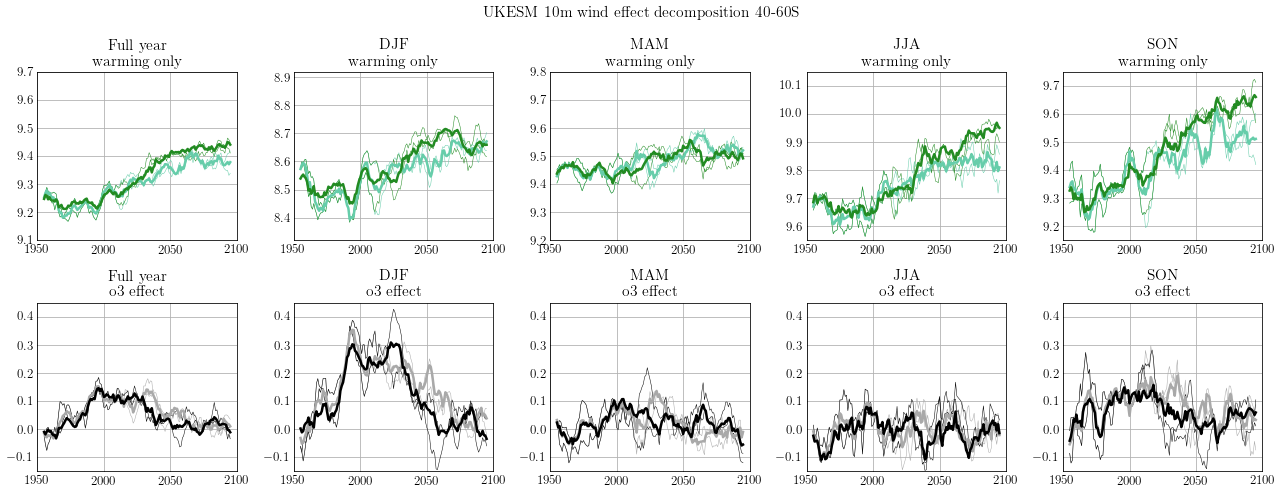

In [38]:
latdegs = ['40-60S']#,'30-70S']

for latdeg in latdegs:


    fact = 1
    fig, axs = plt.subplots(2,5, figsize=(18*fact, 7*fact), sharex=False, sharey=False)
    axs = axs.ravel()

    scens = ['2A','2B','2AM2','2BM2','2AEM','2BEM']
    scens1 = ['1A','1B','1AM2','1BM2','1AEM','1BEM']
    stl = ['1AEM','2AEM','1BEM','2BEM']

    ts = ['DJF','MAM','JJA','SON']

    for s in scens:
        tdir = '/gpfs/data/greenocean2/software/products/windsFromComponents/dailyStandard/intProc/'
        td = xr.open_dataset(f'{tdir}/scen{s}_UKESM_{latdeg}_mean_wspd_ts_1950-2099.nc')
        g = td.groupby('time_counter.year').mean()
        g2 = np.nanmean(td.wspd10m[0:10]) #first 10 yrs
        tv_rol = g.rolling(year=10, center=True).mean()

        #axs[0].plot(g.year,g.wspd10m, color = m3dict[s]['color'], linewidth = m3dict[s]['linewidth'],)
        if s in stl:
            axs[0].plot(tv_rol.year,tv_rol.wspd10m, color = m3dict[s]['color'],\
                        linewidth = m3dict[s]['linewidth'], label = m3dict[s]['name'])    
        else:
            axs[0].plot(tv_rol.year,tv_rol.wspd10m, color = m3dict[s]['color'],\
                        linewidth = m3dict[s]['linewidth'],)
        for i in range(0,4):
            g = td.sel(time_counter=(td['time_counter.season'] == ts[i])).groupby('time_counter.year').mean()
            g2 = np.nanmean(td.wspd10m[0:10])
            tv_rol = g.rolling(year=10, center=True).mean()
            axs[i+1].plot(tv_rol.year,tv_rol.wspd10m, color = m3dict[s]['color'], linewidth = m3dict[s]['linewidth'],)

    tmin = [9.1,8.32,9.2,9.55,9.15]
    if latdeg == '30-70S':
        tmin = [8.2,7.35,8.35,8.8,8.25]
    tits = ['Full year \n warming only','DJF\n warming only','MAM\n warming only','JJA\n warming only','SON\n warming only'] 
    ofs = 0.6
    for i in range(0,5):

        axs[i].set_xlim([1950,2100])
        axs[i].set_xticks(np.arange(1950,2150,50))
        # axs[i].set_xticklabels([])
        axs[i].set_ylim([tmin[i],tmin[i]+ofs])
        axs[i].tick_params(axis='x', length=0.5)
        axs[i].tick_params(axis='y', length=0.5)
        axs[i].grid()

        axs[i].set_title(tits[i])


    ##### ozone component

    for s in range(0,6):
        tdir = '/gpfs/data/greenocean2/software/products/windsFromComponents/dailyStandard/intProc/'
        td2 = xr.open_dataset(f'{tdir}/scen{scens[s]}_UKESM_{latdeg}_mean_wspd_ts_1950-2099.nc')
        td1 = xr.open_dataset(f'{tdir}/scen{scens1[s]}_UKESM_{latdeg}_mean_wspd_ts_1950-2099.nc')
        td = td1 - td2

        g = td.groupby('time_counter.year').mean()
        g2 = np.nanmean(td.wspd10m[0:10]) #first 10 yrs
        tv_rol = g.rolling(year=10, center=True).mean()

        #g1 = td.groupby('time_counter.year').mean()

        tv_rol = g.rolling(year=10, center=True).mean()

        #axs[0].plot(g.year,g.wspd10m, color = m3dict[s]['color'], linewidth = m3dict[s]['linewidth'],)
        if s in stl:
            axs[0+5].plot(tv_rol.year,tv_rol.wspd10m, color = m3dict[scens1[s]]['color'],\
                        linewidth = m3dict[scens1[s]]['linewidth'], label = m3dict[scens1[i]]['name'])    
        else:
            axs[0+5].plot(tv_rol.year,tv_rol.wspd10m, color = m3dict[scens1[s]]['color'],\
                        linewidth = m3dict[scens1[s]]['linewidth'],)
        for i in range(0,4):
            g = td.sel(time_counter=(td['time_counter.season'] == ts[i])).groupby('time_counter.year').mean()
            g2 = np.nanmean(td.wspd10m[0:10])
            tv_rol = g.rolling(year=10, center=True).mean()
            axs[i+6].plot(tv_rol.year,tv_rol.wspd10m, color = m3dict[scens1[s]]['color'], linewidth = m3dict[scens1[s]]['linewidth'],)

    tmin = [-0.15,-0.15,-0.15,-0.15,-0.15,]
    if latdeg == '30-70S':
        tmin = [-0.15,-0.15,-0.15,-0.15,-0.15,]
    tits = ['Full year \n o3 effect','DJF\n o3 effect','MAM\n o3 effect','JJA\n o3 effect','SON\n o3 effect']    
    ofs = 0.6
    for i in range(0,5):

        axs[i+5].set_xlim([1950,2100])
        axs[i+5].set_xticks(np.arange(1950,2150,50))
        # axs[i].set_xticklabels([])
        axs[i+5].set_ylim([tmin[i],tmin[i]+ofs])
        axs[i+5].tick_params(axis='x', length=0.5)
        axs[i+5].tick_params(axis='y', length=0.5)
        axs[i+5].grid()
        axs[i+5].set_title(tits[i])

        fig.suptitle(f'UKESM 10m wind effect decomposition {latdeg}')
        plt.tight_layout()

        #fig.savefig(f'./plts/decomposition_{latdeg}_3M_1950-2100-full.png')